In [41]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense,  BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os

Change fast run to False for 50 epochs and change to True for 3 epochs

In [42]:
train_files = '../input/train/'
earlystop = EarlyStopping(patience=10)
FAST_RUN = True
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

model = Sequential()

In [43]:

model.add(Conv2D(32, (3,3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_12 (Bat  (None, 126, 126, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 63, 63, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_13 (Bat  (None, 61, 61, 64)      

In [44]:
filenames = os.listdir(train_files)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog' :
        categories.append('dog')
    else:
        categories.append('cat')
df = pd.DataFrame({
    'filename' : filenames,
    'category' : categories
})

In [45]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

Prepare the data

In [46]:
# validate the df
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<AxesSubplot:>

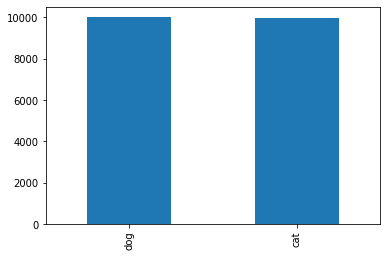

In [47]:
train_df['category'].value_counts().plot.bar()

<AxesSubplot:>

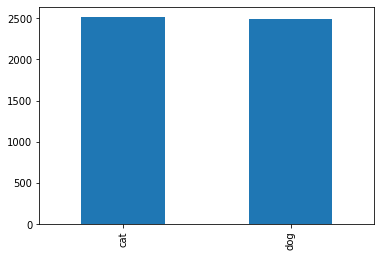

In [48]:
validate_df['category'].value_counts().plot.bar()

In [49]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

Training Generator

In [50]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    train_files, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [51]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    train_files, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [52]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    train_files, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


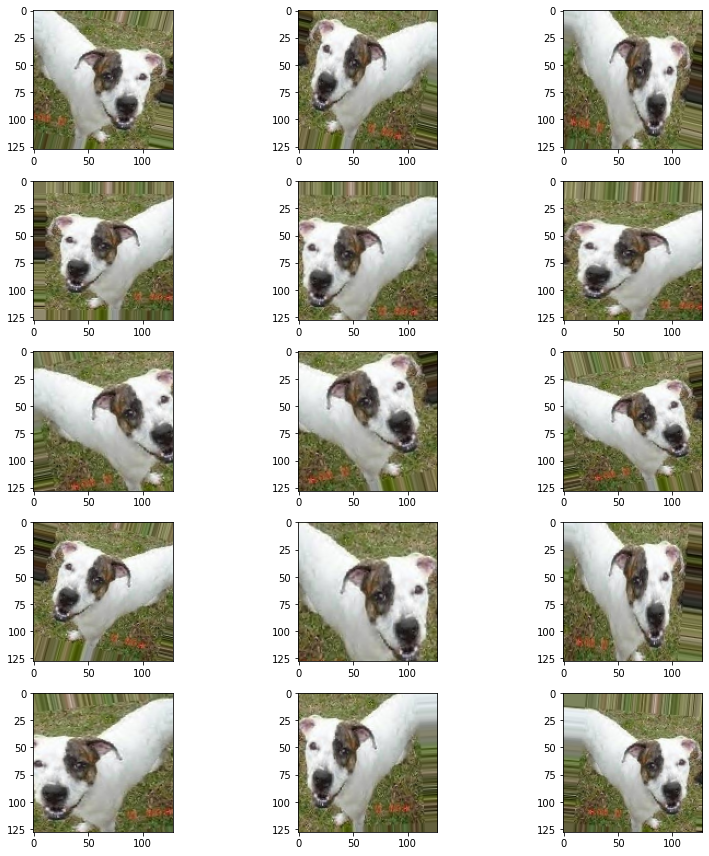

In [53]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [54]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/3


C:\Users\jdani\AppData\Local\Temp\ipykernel_14936\612699584.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


1333/1333 [==============================] - 221s 164ms/step - loss: 0.7380 - accuracy: 0.6355 - val_loss: 0.5534 - val_accuracy: 0.7207 - lr: 0.0010
Epoch 2/3
1333/1333 [==============================] - 219s 164ms/step - loss: 0.5537 - accuracy: 0.7273 - val_loss: 0.5180 - val_accuracy: 0.7520 - lr: 0.0010
Epoch 3/3
1333/1333 [==============================] - 225s 169ms/step - loss: 0.5088 - accuracy: 0.7542 - val_loss: 0.4946 - val_accuracy: 0.7720 - lr: 0.0010


In [79]:
model.save_weights("weights.h5")
model.save('model.h5')